<a href="https://colab.research.google.com/github/shanilev123456/Final-Project-ds/blob/master/FCNN_model%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/shanilev123456/Final-Project-ds/blob/master/FCNN_model%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import copy

!pip install ipython-autotime
%load_ext autotime


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 707 ms (started: 2025-05-27 16:11:55 +03:00)


## Import Data

In [ ]:
# from google.colab import files
# uploaded = files.upload()

time: 323 μs (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
df = pd.read_csv("cleaned_data.csv")
df.head()

,Units,Area m2,dist_to_kindergarten,is_kindergarten_within_radius,dist_to_school,is_school_within_radius,dist_to_university,is_university_within_radius,dist_to_bus_stop,is_bus_stop_within_radius,...,"City_שהם , נכים",City_שלומי,"City_שלומי , יערית",City_שער אפרים,"City_שער אפרים , שער אפרים",City_שריגים(לי און,"City_שריגים(לי און , מועצה אזורית מטה יהודה","City_תל אביב יפו , בצרה",City_תל מונד,City_תלמי יחיאל
0,0.2,0.639225,0.031609,0.0,0.084843,0.0,0.267139,0.0,0.031318,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0.2,0.638015,0.031609,0.0,0.084843,0.0,0.267139,0.0,0.031318,1.0,...,0,0,0,0,0,0,0,0,0,0
2,0.2,0.638015,0.031609,0.0,0.084843,0.0,0.267139,0.0,0.031318,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.167070,0.282213,0.0,0.313402,0.0,0.057636,0.0,0.034334,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.167070,0.282213,0.0,0.313402,0.0,0.057636,0.0,0.034334,1.0,...,0,0,0,0,0,0,0,0,0,0


time: 113 ms (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
df = df.dropna()
city_columns = [col for col in df.columns if col.startswith("City_")]
df['city'] = df[city_columns].idxmax(axis=1).str.replace('City_', '')

city_counts = df['city'].value_counts()
valid_cities = city_counts[city_counts > 1].index
df = df[df['city'].isin(valid_cities)].copy()


city_columns = [col for col in df.columns if col.startswith("City_")]

target_column = "Price per m2"
y = df[target_column]
X = df.drop(columns=[target_column])

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['city']
)

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42,
    stratify=X_train_full['city']
)

X_train_part = X_train_part.drop(columns=['city'])
X_val = X_val.drop(columns=['city'])
X_test = X_test.drop(columns=['city'])

time: 76.1 ms (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
X_columns = X_train_part.columns
X_columns.to_series().to_csv("model_columns.csv", index=False, header=False)

time: 6.24 ms (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
if isinstance(X_train_part, pd.DataFrame):
    X_train_part = X_train_part.values
if isinstance(X_val, pd.DataFrame):
    X_val = X_val.values
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.values

time: 3.65 ms (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
X_train_part = X_train_part.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

X_train_part = np.array(X_train_part, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

time: 4.36 ms (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu
time: 1.16 ms (started: 2025-05-27 16:11:56 +03:00)


In [ ]:
# tensors
X_train_tensor = torch.tensor(X_train_part, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_part.values.reshape(-1,1), dtype=torch.float32).to(device)   # ← .values + reshape
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32).to(device)
y_val_tensor   = torch.tensor(y_val.values.reshape(-1,1),   dtype=torch.float32).to(device)   # ← same here
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test.values.reshape(-1,1),  dtype=torch.float32).to(device)   # ← and here

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor,   y_val_tensor),   batch_size=64)

time: 10.8 ms (started: 2025-05-27 16:11:56 +03:00)


## Model Architecture

In [ ]:
class MLPmodel(nn.Module):
    def __init__(self, input_dim):
        super(MLPmodel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.SiLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.SiLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = MLPmodel(input_dim=X_train_part.shape[1]).to(device)


time: 9.9 ms (started: 2025-05-27 16:11:56 +03:00)


## Define hyper-parameters & Training model

In [ ]:
# criterion = nn.MSELoss()
criterion = nn.HuberLoss(delta=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
early_stop_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses = []
val_losses = []

best_model = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered.")
            break


Epoch 1, Train Loss: 0.00284, Val Loss: 0.00068
Epoch 2, Train Loss: 0.00070, Val Loss: 0.00054
Epoch 3, Train Loss: 0.00053, Val Loss: 0.00068
Epoch 4, Train Loss: 0.00042, Val Loss: 0.00045
Epoch 5, Train Loss: 0.00040, Val Loss: 0.00050
Epoch 6, Train Loss: 0.00036, Val Loss: 0.00044
Epoch 7, Train Loss: 0.00037, Val Loss: 0.00047
Epoch 8, Train Loss: 0.00034, Val Loss: 0.00046
Epoch 9, Train Loss: 0.00031, Val Loss: 0.00044
Epoch 10, Train Loss: 0.00029, Val Loss: 0.00042
Epoch 11, Train Loss: 0.00032, Val Loss: 0.00045
Epoch 12, Train Loss: 0.00029, Val Loss: 0.00043
Epoch 13, Train Loss: 0.00028, Val Loss: 0.00042
Epoch 14, Train Loss: 0.00029, Val Loss: 0.00043
Epoch 15, Train Loss: 0.00027, Val Loss: 0.00043
Early stopping triggered.
time: 857 ms (started: 2025-05-27 16:11:56 +03:00)


## Plotting Training and Validation Metrics

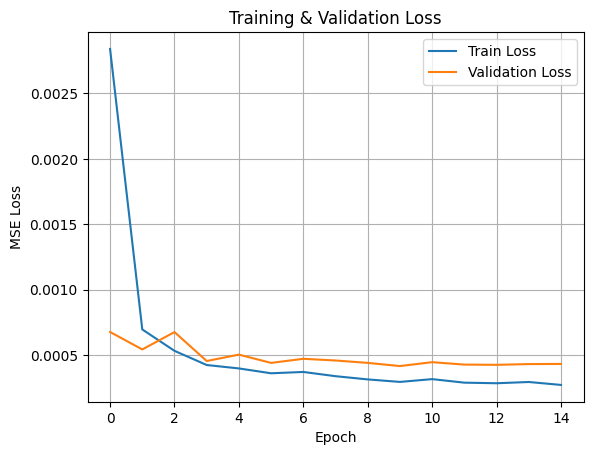

time: 59.8 ms (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Saving trained model

In [ ]:
model.load_state_dict(best_model)

torch.save(model.state_dict(), "mlp_model.pt")
print("Model saved to mlp_model.pt")

Model saved to mlp_model.pt
time: 5.45 ms (started: 2025-05-27 16:11:57 +03:00)


## Evaluation

In [ ]:
model.load_state_dict(best_model)
model.eval()

with torch.no_grad():
    y_train_pred = model(torch.tensor(X_train_part, dtype=torch.float32).to(device)).cpu().numpy()
    y_val_pred = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
    y_test_pred = model(X_test_tensor).cpu().numpy()

print("Train set:")
print(f"MAE: {mean_absolute_error(y_train_part, y_train_pred):.4f}")
print(f"MSE: {mean_squared_error(y_train_part, y_train_pred):.4f}")
print(f"R² : {r2_score(y_train_part, y_train_pred):.4f}")

print("\nValidation set:")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"MSE: {mean_squared_error(y_val, y_val_pred):.4f}")
print(f"R² : {r2_score(y_val, y_val_pred):.4f}")

print("\nTest set:")
print(f"MAE: {mean_absolute_error(y_test_tensor.cpu().numpy(), y_test_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test_tensor.cpu().numpy(), y_test_pred):.4f}")
print(f"R² : {r2_score(y_test_tensor.cpu().numpy(), y_test_pred):.4f}")


Train set:
MAE: 0.0135
MSE: 0.0004
R² : 0.9501

Validation set:
MAE: 0.0161
MSE: 0.0011
R² : 0.8794

Test set:
MAE: 0.0142
MSE: 0.0005
R² : 0.9375
time: 11 ms (started: 2025-05-27 16:11:57 +03:00)


## Test environment

In [ ]:
import pandas as pd
import json

time: 130 μs (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
X_columns = pd.read_csv("model_columns.csv", header=None).squeeze().tolist()

time: 3.57 ms (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
with open('scaler_minmax.json', 'r') as f:
    scaler_minmax = json.load(f)

with open('price_minmax.json', 'r') as f:
    price_minmax = json.load(f)

time: 931 μs (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
def normalize_value(value, min_val, max_val):
    if max_val > min_val:
        return (value - min_val) / (max_val - min_val)
    else:
        return 0.0

def find_all_columns_by_substring(columns, value):
    value = str(value).strip().lower()
    matches = [col for col in columns if value in col.lower()]
    return matches

def find_columns_exact_match(columns, value):
    value = str(value).strip().lower()
    matches = [col for col in columns if col.lower() == value]
    return matches

time: 363 μs (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
def predict_price_mlp(user_input: dict, model, X_columns, scaler_minmax, price_minmax, default_values=None):

    if default_values is None:
        default_values = {
             'Units': 1,
            'Area m2': 500,
            'block': '0.0',
            'Committee year': '2025.0',
            'committee month': '6.0',
            'region': 'Unknown',
            'city': 'Unknown',
            'dist_to_kindergarten': 500,
            'dist_to_school': 500,
            'dist_to_university': 1000,
            'dist_to_bus_stop': 200,
            'dist_to_train_station': 1500,
            'dist_to_park': 300,
            'dist_to_mall': 1000,
            'dist_to_supermarket': 300,
            'dist_to_beach': 5000,
            'dist_to_place_of_worship': 400
        }

    input_df = pd.DataFrame([0] * len(X_columns), index=X_columns).T

    # handling numeric features
    for col in ['Units', 'Area m2']:
        val = float(user_input.get(col, default_values[col]))
        min_val = scaler_minmax[col]['min']
        max_val = scaler_minmax[col]['max']
        input_df.at[0, col] = normalize_value(val, min_val, max_val)

    block_col = f"Block_{user_input.get('block', default_values['block'])}"
    if block_col in X_columns:
        input_df.at[0, block_col] = 1

    year_col = f"Committee_year_{user_input.get('Committee year', default_values['Committee year'])}"
    month_col = f"Committee_month_{user_input.get('committee month', default_values['committee month'])}"
    if year_col in X_columns:
        input_df.at[0, year_col] = 1
    if month_col in X_columns:
        input_df.at[0, month_col] = 1

    distance_features = [
        'dist_to_kindergarten', 'dist_to_school', 'dist_to_university',
        'dist_to_bus_stop', 'dist_to_train_station', 'dist_to_park',
        'dist_to_mall', 'dist_to_supermarket', 'dist_to_beach',
        'dist_to_place_of_worship']

    for col in distance_features:
        val = float(user_input.get(col, default_values[col]))
        min_val = scaler_minmax[col]['min']
        max_val = scaler_minmax[col]['max']
        input_df.at[0, col] = normalize_value(val, min_val, max_val)

    for feature in ['region', 'city']:
        val = user_input.get(feature, default_values[feature])
        matches = find_all_columns_by_substring(X_columns, val)
        for col in matches:
            if col in input_df.columns:
                input_df.at[0, col] = 1


      #Exeption in case no values have got
    if input_df.empty:
        raise ValueError("No records were found match to the query.")


    input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor).item()

    price_min = price_minmax["min"]
    price_max = price_minmax["max"]
    predicted_price_per_m2 = prediction * (price_max - price_min) + price_min

    return predicted_price_per_m2

time: 932 μs (started: 2025-05-27 16:11:57 +03:00)


### Testing on existing record in Dataset

In [ ]:
import torch
import pandas as pd

def predict_from_record(row, model, price_minmax):

    # input_df = pd.DataFrame([0] * len(row.drop(labels='Price per m2', errors='ignore').index),
    #                         index=row.drop(labels='Price per m2', errors='ignore').index).T
    input_df = pd.DataFrame([0] * len(X_columns), index=X_columns).T

    # numeric features
    numeric_features = ['Units', 'Area m2']
    for col in numeric_features:
        if col in row:
            input_df.at[0, col] = row[col]

    # copy the cols which turn on to '1'
    for col in row.index:
        if col.startswith(('Block_', 'City_', 'Region_', 'Committee_year_', 'Committee_month_')) and row[col] == 1:
            input_df.at[0, col] = 1

    input_tensor = torch.tensor(input_df.values, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        prediction_norm = model(input_tensor).item()

    price_min = price_minmax["min"]
    price_max = price_minmax["max"]
    prediction = prediction_norm * (price_max - price_min) + price_min

    true_norm = row['Price per m2']
    true_price = true_norm * (price_max - price_min) + price_min

    print(f"Prediction: {prediction:,.2f} ₪")
    print(f"Actual price: {true_price:,.2f} ₪")
    print(f"Deviation: {abs(prediction - true_price) / true_price * 100:.2f}%")
    return prediction, true_price

time: 571 μs (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
row = df.sample(1).iloc[0]
predict_from_record(row, model, price_minmax)

Prediction: 554.96 ₪
Actual price: 634.00 ₪
Deviation: 12.47%


/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/3875665872.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3946731234866828' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = row[col]


(554.9591160616734, np.float64(633.9999999999998))

time: 5.21 ms (started: 2025-05-27 16:11:57 +03:00)


## Random records from data

In [ ]:
def evaluate_on_random_samples(df, model, scaler_minmax, price_minmax, X_columns, n=20):

    # X_columns = df.drop(columns=["Price per m2"]).columns
    errors = []

    for _, row in df.sample(n=n, random_state=42).iterrows():
        input_df = pd.DataFrame([0] * len(X_columns), index=X_columns).T

        numeric_features = ['Units', 'Area m2',
                            'dist_to_kindergarten', 'dist_to_school', 'dist_to_university',
                            'dist_to_bus_stop', 'dist_to_train_station', 'dist_to_park',
                            'dist_to_mall', 'dist_to_supermarket', 'dist_to_beach',
                            'dist_to_place_of_worship']

        for col in numeric_features:
            val = row[col]
            min_val = scaler_minmax[col]['min']
            max_val = scaler_minmax[col]['max']
            input_df.at[0, col] = normalize_value(val, min_val, max_val)

        for col in row.index:
            if row[col] == 1 and col in input_df.columns:
                input_df.at[0, col] = 1

        input_tensor = torch.tensor(input_df.values, dtype=torch.float32).to(device)
        model.eval()
        with torch.no_grad():
            pred_norm = model(input_tensor).item()

        pred = pred_norm * (price_minmax["max"] - price_minmax["min"]) + price_minmax["min"]
        true = row["Price per m2"] * (price_minmax["max"] - price_minmax["min"]) + price_minmax["min"]
        error_pct = abs(pred - true) / true * 100
        errors.append(error_pct)

    print(f"Mean error: {np.mean(errors):.2f}%") # ממוצע שגיאה
    print(f"Median error: {np.median(errors):.2f}%") # חציון שגיאה
    print(f"Maximum error: {np.max(errors):.2f}%")
    print(f"Minimum error: {np.min(errors):.2f}%")

time: 648 μs (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
evaluate_on_random_samples(df, model, scaler_minmax, price_minmax,X_columns, n=20)

Mean error: 96.24%
Median error: 53.38%
Maximum error: 528.47%
Minimum error: 3.23%
time: 39.6 ms (started: 2025-05-27 16:11:57 +03:00)


/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/1495711449.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.16' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/1495711449.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.20991211767671736' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/1495711449.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0011401317221647197' has dtype inco

# New query

In [ ]:
# עבור רשומה זו המחיר הסופי הינו - 440,000
user_input = {
    'Units': 1,
    'Area m2': 543,
    'block': '38761.0',
    'Committee year': '2024.0',
    'committee month': '7.0',
    'region': 'דרום',
    'city': 'באר שבע',
    'dist_to_kindergarten': 500,
    'dist_to_school': 500,
    'dist_to_university': 1000,
    'dist_to_bus_stop': 200,
    'dist_to_train_station': 1500,
    'dist_to_park': 300,
    'dist_to_mall': 1000,
    'dist_to_supermarket': 300,
    'dist_to_beach': 5000,
    'dist_to_place_of_worship': 400
}

predicted_price = predict_price_mlp(user_input, model, X_columns, scaler_minmax, price_minmax)
total_price = predicted_price * user_input['Area m2']

print(f"\nPredicted price per m²: {predicted_price:,.2f} ₪")
print(f"Total price for this area: {total_price:,.2f} ₪")


Predicted price per m²: 547.98 ₪
Total price for this area: 297,550.83 ₪
time: 3.44 ms (started: 2025-05-27 16:11:57 +03:00)


/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/2377787459.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4467312348668281' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/2377787459.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.007712030170146494' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_df.at[0, col] = normalize_value(val, min_val, max_val)
/var/folders/lb/824pdw_j27x5fbnfxl4hkx880000gn/T/ipykernel_9994/2377787459.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.007509882776203064' has

## Validation of input
#### checks if the input match the columns in the model.

In [ ]:
def validate_input_against_columns(user_input, X_columns):
    warnings = []
    activated = []

    block = user_input.get('block')
    if block is not None:
        block_col = f"Block_{float(block):.1f}"
        if block_col in X_columns:
            activated.append(block_col)
        else:
            warnings.append(f"Block column '{block_col}' not found.")

    year = user_input.get('Committee year')
    if year is not None:
        year_col = f"Committee_year_{float(year):.1f}"
        if year_col in X_columns:
            activated.append(year_col)
        else:
            warnings.append(f"Committee year column '{year_col}' not found.")

    month = user_input.get('committee month')
    if month is not None:
        month_col = f"Committee_month_{float(month):.1f}"
        if month_col in X_columns:
            activated.append(month_col)
        else:
            warnings.append(f"Committee month column '{month_col}' not found.")

    for field in ['city', 'region']:
        val = user_input.get(field, '').strip().lower()
        matches = [col for col in X_columns if val in col.lower()]
        if matches:
            activated.extend(matches)
        else:
            warnings.append(f"No column {field} found.")

    if warnings:
        print("Warnings features:")
        for w in warnings:
            print(" -", w)

    if activated:
        print("\nColumns that will be activated for this input:")
        for col in activated:
            print("  -", col)
    else:
        print("\n No one-hot columns matched the input.")

time: 752 μs (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
validate_input_against_columns(user_input, X.columns)


Columns that will be activated for this input:
  - Block_38761.0
  - Committee_year_2024.0
  - Committee_month_7.0
  - City_באר שבע , הרקפות
  - City_באר שבע , כלניות
  - City_באר שבע , כלניות לנכים
  - City_באר שבע , נאות לון
  - City_באר שבע , נווה נוי
  - City_באר שבע , רמות
  - City_באר שבע , רקפות
  - Region_דרום
  - City_אריאל , דרום מזרח
time: 270 μs (started: 2025-05-27 16:11:57 +03:00)


### Export all predictions

In [ ]:
!pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
time: 403 ms (started: 2025-05-27 16:11:57 +03:00)


In [ ]:
def export_predictions_to_excel(X_data, y_true, model, price_minmax, filename="model_predictions.xlsx"):
    model.eval()
    with torch.no_grad():
        preds_norm = model(torch.tensor(X_data, dtype=torch.float32).to(device)).cpu().numpy().flatten()

    price_min = price_minmax["min"]
    price_max = price_minmax["max"]

    def inv(x): return x * (price_max - price_min) + price_min

    if isinstance(y_true, pd.Series):
        y_true_array = y_true.to_numpy()
    else:
        y_true_array = y_true

    if len(y_true_array.shape) > 1:
        y_true_array = y_true_array.flatten()

    preds_shekel = inv(preds_norm)
    y_true_shekel = inv(y_true_array)

    # preds_shekel = inv(preds_norm)
    # y_true_shekel = inv(y_true.flatten())

    errors = np.abs(preds_shekel - y_true_shekel)
    errors_pct = errors / y_true_shekel * 100

    df_results = pd.DataFrame({
        "Predicted Price per m² (₪)": preds_shekel,
        "Actual Price per m² (₪)": y_true_shekel,
        "Absolute Error (₪)": errors,
        "Percentage Error (%)": errors_pct
    })

    df_results.to_excel(filename, index=False)
    print(f"Predictions exported to '{filename}' with {len(df_results)} rows.")
    mean_pct_error = errors_pct.mean()
    print(f"Mean Percentage Error: {mean_pct_error:.2f}%")
    median_pct_error = np.median(errors_pct)
    print(f"Median Percentage Error: {median_pct_error:.2f}%")


time: 777 μs (started: 2025-05-27 16:11:58 +03:00)


In [ ]:
export_predictions_to_excel(X_test, y_test, model, price_minmax)

Predictions exported to 'model_predictions.xlsx' with 1036 rows.
Mean Percentage Error: 27.81%
Median Percentage Error: 13.88%
time: 40.2 ms (started: 2025-05-27 16:11:58 +03:00)
